In [1]:
%run ../definitions.ipynb

In [2]:
# Oct 31 values
fs_nr = 0.30987122
fs_er = 0.16578436

In [3]:
def get_ratio(fs):
    return fs/(1-fs)

In [4]:
get_ratio(fs_nr)

0.44900492339994863

### Exponentials!

In [5]:
def Iex(t, tau):
    return np.exp(-t/tau)

def Ir(t, tau, tr):
    lambda_s = 1/tau # lambda scintillation
    lambda_r = 1/tr
    n0 = 1
    return n0 * lambda_r * lambda_s / (lambda_s - lambda_r) * (np.exp(- lambda_r * t) - np.exp(- lambda_s * t))

(0, 0.05)

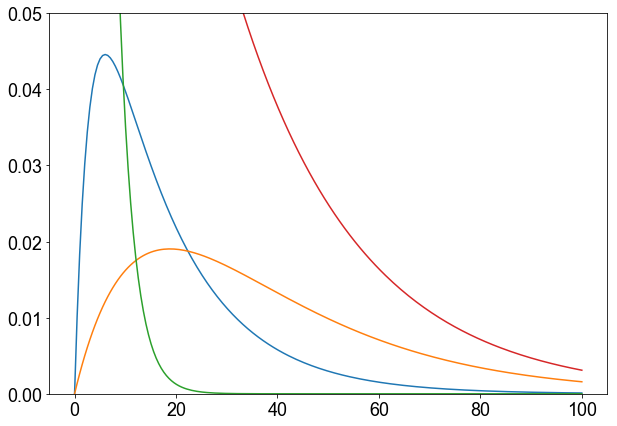

In [6]:
t_plot = np.linspace(0, 100, 200)

plt.plot(t_plot, Ir(t_plot, 3, 15))
plt.plot(t_plot, Ir(t_plot, 24, 15))

plt.plot(t_plot, Iex(t_plot, 3))
plt.plot(t_plot, 0.2 * Iex(t_plot, 24))

plt.ylim(0, 0.05)
# plt.yscale('log')
# plt.ylim(1e-4, 1)

In [7]:
t_plot[np.argmax(Ir(t_plot, 3, 15))]

6.0301507537688437

In [8]:
t_plot[np.argmax(Ir(t_plot, 24, 15))]

18.5929648241206

In [9]:
t_range = (40, 100)
mask = (t_plot > t_range[0]) & (t_plot < t_range[1])
x_fit = t_plot[mask]
y_fit = Ir(t_plot, 24, 30)[mask]

def exp(t, a0, tau):
    return a0 * np.exp(-t/tau)

scipy.optimize.curve_fit(exp, x_fit, y_fit, p0=[0.1, 24])

(array([  3.04235680e-02,   4.75306567e+01]),
 array([[  1.02033390e-07,  -1.21662741e-04],
        [ -1.21662741e-04,   1.54533094e-01]]))

In [10]:
import scipy.interpolate
import numpy as np

def cdf_inverse(tau, tr, tmax, nsteps = 100):
    t = np.linspace(0, tmax, nsteps)
    return scipy.interpolate.interp1d(cdf_r(t, tau, tr), t, bounds_error=False)

def cdf_r(t, tau, tr):
    lambda_s = 1/tau # lambda scintillation
    lambda_r = 1/tr
    A = lambda_s * lambda_r / (lambda_s - lambda_r)
    return A * ((1/lambda_s) * (np.exp(- lambda_s * t) -1) - (1/lambda_r) * (np.exp(- lambda_r * t) -1))

def simulate_recombination_times(nphotons, tau, tr, tmax, nsteps):
    cdf_inv_f = cdf_inverse(tau, tr, tmax, nsteps)
    # Check what the maximum time CDF value is
    cdf_max = cdf_r(tmax, tau, tr)
    if (1 - cdf_max) > 0.05:
        print('Warning: %.2f percent of photons discarted in recombination simulation.' % ((1 - cdf_max) * 100))
    times = cdf_inv_f(np.random.rand(nphotons) * cdf_max)
    return times

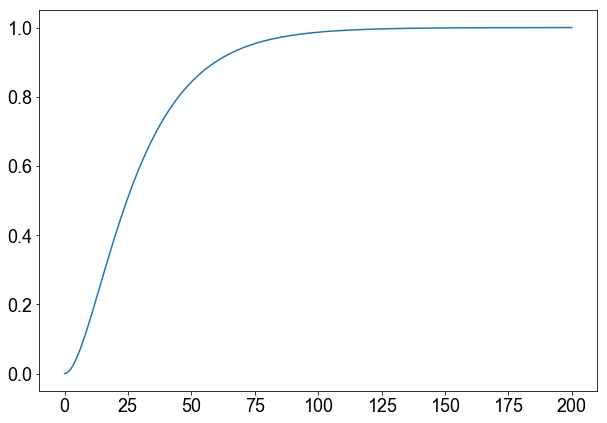

In [11]:
t_plot = np.linspace(0, 200, 400)
plt.plot(t_plot, cdf_r(t_plot, 10, 20))

In [12]:
cdf_inv_f = cdf_inverse(10, 20, 150, 1000)

In [13]:
nsamples = 100000

In [14]:
times  = cdf_inv_f(np.random.rand(nsamples))
print(sum(np.isnan(times)))
times = times[np.invert(np.isnan(times))]

131


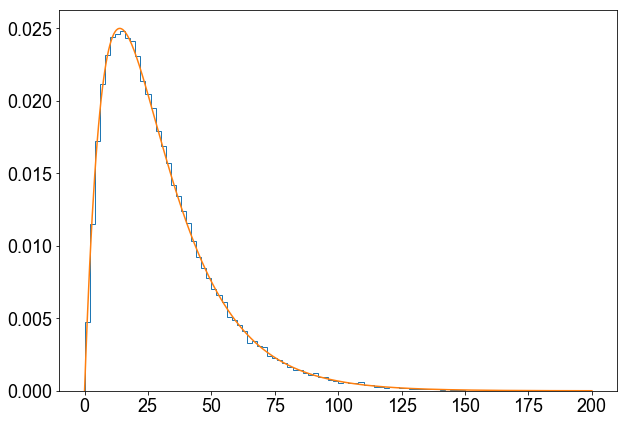

In [15]:
plt.hist(times, bins=100, range=(0, 200), histtype='step', normed=True )
plt.plot(t_plot, Ir(t_plot, 10, 20))
plt.show()

In [16]:
%%time
times = simulate_recombination_times(2e5, 5, 20, 200, 200)

CPU times: user 16 ms, sys: 8 ms, total: 24 ms
Wall time: 20.7 ms


/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [17]:
def Iex2(t, tau):
    '''Plotting purpose one'''
    return (t > 0) * Iex(t, tau)

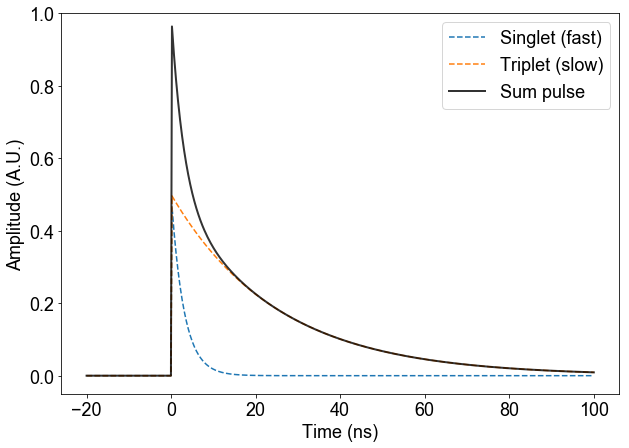

In [18]:
t_plot = np.linspace(-20, 100, 500)
A1 = 0.5
A2 = 0.5
plt.plot(t_plot, A1 * Iex2(t_plot, 3), label = 'Singlet (fast)', ls='--')
plt.plot(t_plot, A2 * Iex2(t_plot, 25), label = 'Triplet (slow)', ls='--')
plt.plot(t_plot, A1 * Iex2(t_plot, 3) + A2 * Iex2(t_plot, 25), label = 'Sum pulse', 
         color='black', lw=2, alpha=0.8)
plt.legend()
plt.xlabel('Time (ns)')
plt.ylabel('Amplitude (A.U.)')
plt.ylim(-0.05, 1)
plt.savefig('pulse_example.png', bbox_inches='tight')


In [19]:
Iex2(np.linspace(-10, 10, 20), 10)

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.94872948,  0.85393967,  0.76862053,  0.69182583,  0.62270386,
        0.56048804,  0.50448835,  0.45408372,  0.40871514,  0.36787944])

### Estimate of recombination fraction

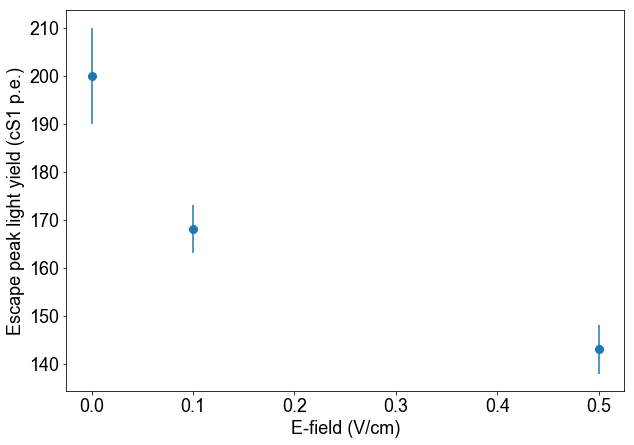

In [20]:
e_field = [0, 0.1, 0.5]
ly = [200, 168, 143]
ly_err = [10, 5, 5]
plt.errorbar(e_field, ly, ly_err, ls='None', marker='.', markersize=16)
plt.xlabel('E-field (V/cm)')
plt.ylabel('Escape peak light yield (cS1 p.e.)')


### Recombination time!

Now ACTUALLY following the derivation by Kubota et al., let's revisit the recombination time dependance...

In [21]:
import scipy.integrate as integrate


def n(t, tr):
    """
    Density of ions and electrons supposing hot electron escape prob. of zero and uniform density
    """
    return 1 / (1 + t/tr)

def Ir2(t, tau, tr):
    '''The intensity of scintillation, AKA the PDF distibution for photons!'''
    if isinstance(t, float) or isinstance(t, int):
        return np.exp(-t/tau) / tau * integrate.quad(lambda x: n(x, tr)**2 * np.exp(x/tau), 0, t)[0]
    else:
        return np.array([Ir2(_t, tau, tr) for _t in t])

def Ir2_cdf(t, tau, tr):
    pdf = Ir2(t, tau, tr)
    return np.cumsum(pdf) / sum(pdf)

def Ir2_cdf_inv(t, tau, tr):
    cdf = Ir2_cdf(t, tau, tr)
    return scipy.interpolate.interp1d(cdf, t)

def Ir2_times_sample(nphotons, tau, tr, tmax, nsteps):
    t = np.linspace(0, tmax, nsteps)
    return Ir2_cdf_inv(t, tau, tr)(np.random.rand(nphotons))

In [22]:
Ir2(12, 22, 15)

0.22148252540625712

#### Quick check of dependence

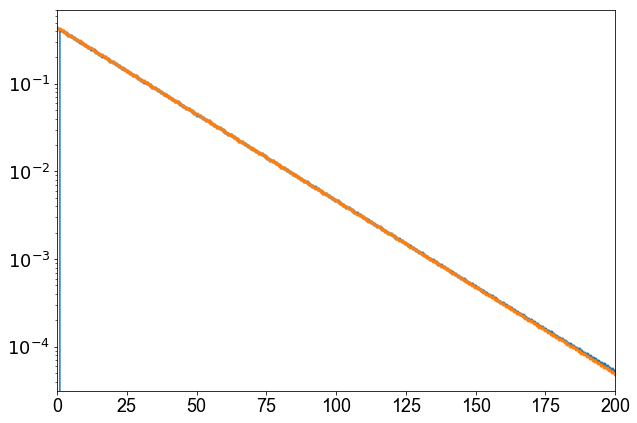

In [23]:
max_t = 200
npoints = 200
x_plot = np.linspace(0, max_t, npoints)
tr = 0.01
tau = 22

y_plot = Ir2(x_plot, tau, tr)
y_plot2 = np.exp(-x_plot / tau)

y_plot = y_plot / sum(y_plot[50:])
y_plot2 = y_plot2 / sum(y_plot2[50:])

plt.plot(x_plot, y_plot, marker='.')
plt.plot(x_plot, y_plot2, marker='.')
plt.xlim(0, max_t)
# plt.ylim(0, 0.3)
plt.yscale('log')

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in true_divide


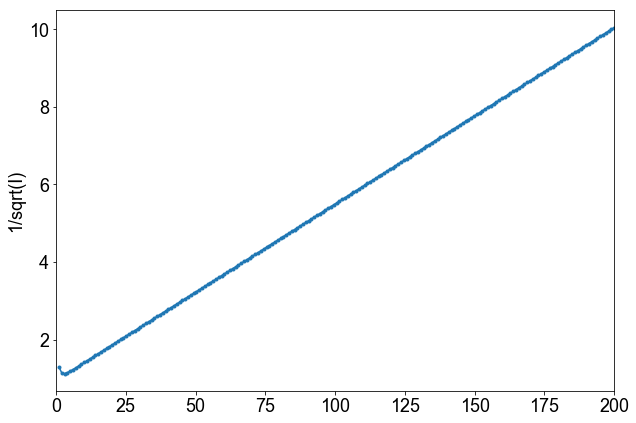

In [24]:
max_t = 200
npoints = 200
x_plot = np.linspace(0, max_t, npoints)
tr = 22
tau = 1

y_plot = Ir2(x_plot, tau, tr)

plt.plot(x_plot, 1/np.sqrt(y_plot), marker='.')
plt.xlim(0, max_t)
plt.ylabel('1/sqrt(I)')
# plt.ylim(0, 0.3)
# plt.yscale('log')

#### CDF

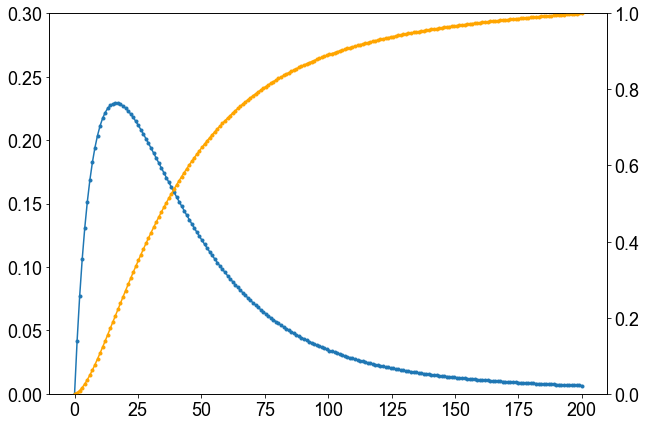

In [25]:
max_t = 200
npoints = 200
x_plot = np.linspace(0, max_t, npoints)
tr = 15
tau = 22
y_plot = Ir2(x_plot, tau, tr)
plt.plot(x_plot, y_plot, marker='.')
plt.xlim(0, max_t)
plt.ylim(0, 0.3)
plt.twinx()
plt.plot(x_plot, Ir2_cdf(x_plot, tau, tr), color='orange', marker='.')
plt.ylim(0, 1)
plt.show()

In [26]:
%%time
bla = Ir2_times_sample(1e5, 22, 15, 200, 200)

CPU times: user 40 ms, sys: 28 ms, total: 68 ms
Wall time: 75.3 ms


/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


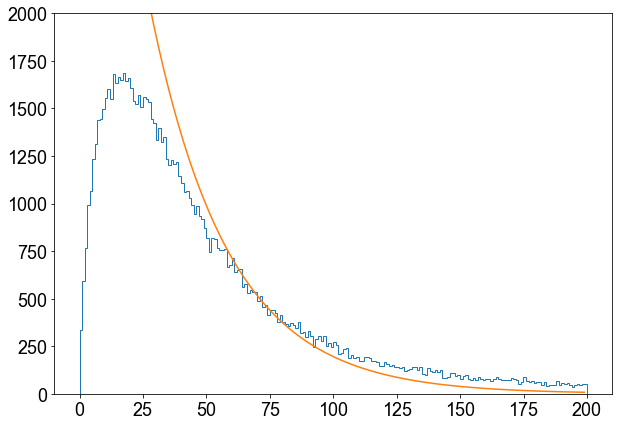

In [27]:
plt.hist(bla, bins=200, histtype='step')
plt.plot(5000*np.exp(-x_plot / 31))
plt.ylim(0, 2000)
plt.show()

### Comparion with other function

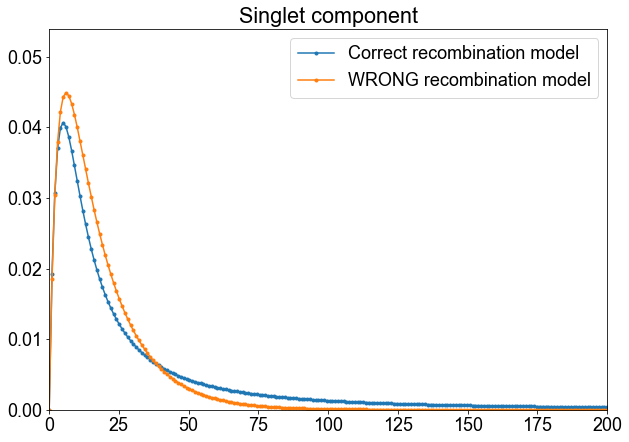

In [28]:
max_t = 200
npoints = 200
x_plot = np.linspace(0, max_t, npoints)
tr = 15
tau = 3
y_plot = Ir2(x_plot, tau, tr)
y_plot_2 = Ir(x_plot, tau, tr)
y_plot = y_plot / sum(y_plot)
y_plot_2 = y_plot_2 / sum(y_plot_2)

plt.plot(x_plot, y_plot, marker='.', label='Correct recombination model')
plt.plot(x_plot, y_plot_2, marker='.', label='WRONG recombination model')
plt.xlim(0, max_t)
plt.ylim(0, max(np.concatenate([y_plot, y_plot_2])) * 1.2)
plt.title('Singlet component')
plt.legend()

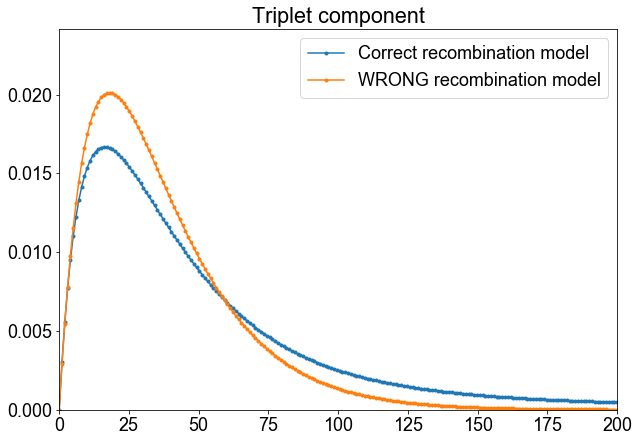

In [29]:
max_t = 200
npoints = 200
x_plot = np.linspace(0, max_t, npoints)
tr = 15
tau = 22
y_plot = Ir2(x_plot, tau, tr)
y_plot_2 = Ir(x_plot, tau, tr)
y_plot = y_plot / sum(y_plot)
y_plot_2 = y_plot_2 / sum(y_plot_2)

plt.plot(x_plot, y_plot, marker='.', label='Correct recombination model')
plt.plot(x_plot, y_plot_2, marker='.', label='WRONG recombination model')
plt.xlim(0, max_t)
plt.ylim(0, max(np.concatenate([y_plot, y_plot_2])) * 1.2)
plt.title('Triplet component')
plt.legend()

In general, it looks like the recombination model here gives a much longer tail and an earlier spike than the previous one. That is good, I guess? 

### Nonzero eta

In [30]:
tau = 15
eta = 0.5

params = [tau, eta]

In [31]:
t = np.linspace(0, 200, 200)

In [32]:
from scipy.integrate import odeint
import scipy.integrate as integrate

def n_eta(t, tr, eta):
    params = [tr, eta]
    y0 = [(1- eta), 1]
    # print(eta)
    
    # Define the differential equations to solve
    def f(y, t, params):
        n_minus, n_plus = y
        tau, eta  = params
        alpha = 1/tau
        derivs = [- alpha * n_minus * n_plus, - alpha * n_minus * n_plus]
        return derivs
    
    psoln = odeint(f, y0, t, args=(params,))
    # Return only the electron number...
    return psoln

def n_product(t, tr, eta):
    psoln = n_eta(t, tr, eta)
    n_e = psoln[:, 0]
    n_holes = psoln[:, 1]
    return 1/ tr * n_e * n_holes


def Ir3(t, tau, tr, eta, tmax, nsteps):
    t_fine = np.linspace(0, tmax, nsteps)
    pdf = np.exp(-t_fine/tau) / tau * np.cumsum(n_product(t_fine, tr, eta) * np.exp(t_fine/tau))
    return np.interp(t, t_fine, pdf)

def Ir3_cdf(t, tau, tr, eta, tmax, nsteps):
    pdf = Ir3(t, tau, tr, eta, tmax, nsteps)
    return np.cumsum(pdf) / sum(pdf)

def Ir3_cdf_inv(t, tau, tr, eta, tmax, nsteps):
    cdf = Ir3_cdf(t, tau, tr, eta, tmax, nsteps)
    # 0 in the cdf means at time zero 
    return scipy.interpolate.interp1d(cdf, t, fill_value=(0, np.inf), bounds_error=False)

def Ir3_times_sample(nphotons, tau, tr, eta, tmax, nsteps):
    t = np.linspace(0, tmax, nsteps)
    return Ir3_cdf_inv(t, tau, tr, eta, tmax, nsteps)(np.random.rand(nphotons))

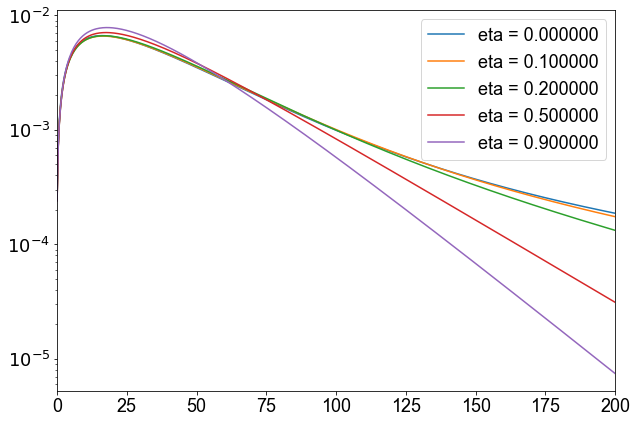

In [33]:
tau = 22
tr = 15
eta = 0

t = np.linspace(0,200, 501)

# pdf1 = Ir2(t, tau, tr)
# pdf2 = Ir3(t, tau, tr, eta=0, tmax=200, nsteps = 1000)
# pdf1 = pdf1 / sum(pdf1)
# pdf2 = pdf2 / sum(pdf2)
# plt.plot(t, pdf1, label='Ir2')
# plt.plot(t, pdf2, label='Ir3')
for eta in [0, 0.1, 0.2, 0.5, 0.9]:
    pdf = Ir3(t, tau, tr, eta, tmax = 200, nsteps =1000)
    pdf = pdf / np.sum(pdf)
    plt.plot(t, pdf, label='eta = %f' % eta)
plt.legend()
plt.xlim(0, 200)
# plt.ylim(0)
plt.yscale('log')

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/ipykernel/__main__.py:44: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


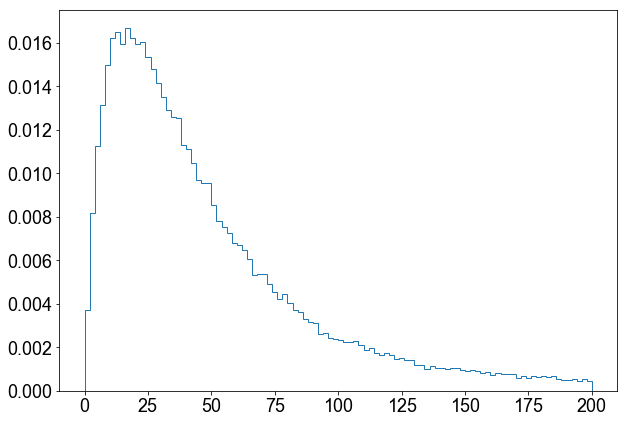

In [34]:
t = np.linspace(0, 200, 201)
times = Ir3_times_sample(1e5, 22, 15, 0, 200, 1000)
plt.hist(times, bins=100, histtype='step', normed = True)
# plt.plot(Ir3())
plt.show()

### NEST 1.0 stuffies

Here the NR ones

In [35]:
def Nex_Ni(E, F, alpha, beta, gamma, delta, zeta):
    '''
    Enter E as recoil energy in keV (NR)
    
    '''
    eps = E_to_eps(E) # E in keV
    sig = sigma(F, gamma, delta)
    return alpha * F**(- zeta) * (1 - np.exp(- beta * eps))
    
def sigma(F, gamma, delta):
    return gamma * F**(- delta)
    
def E_to_eps(E, Z = 54):
    return 11.5* E * Z**(-7/3)

def r(F, Ni, gamma, delta):
    sig = sigma(F, gamma, delta)
    return 1 - (np.log(1 + Ni * sig) / (Ni * sig))

In [36]:
Nex_Ni(10, 0.001, 1.24, 239, 0.01385, 0.062, 0.0472)

1.5760809140056962

In [37]:
Nex_Ni(10, 1, 1.24, 239, 0.01385, 0.062, 0.0472)

1.1375709941375165

In [38]:
r(1000, 0.5, 239, 0.062)

0.94390884047529011

### Nice fig

In [39]:
plt.style.use('latex_prl')

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/matplotlib/style/core.py:53: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  "to style.  Ignoring".format(key))


In [40]:
plt.style.use('latex_prl')
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['font.size'] = 18
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/matplotlib/style/core.py:53: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  "to style.  Ignoring".format(key))


/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/ipykernel/__main__.py:30: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


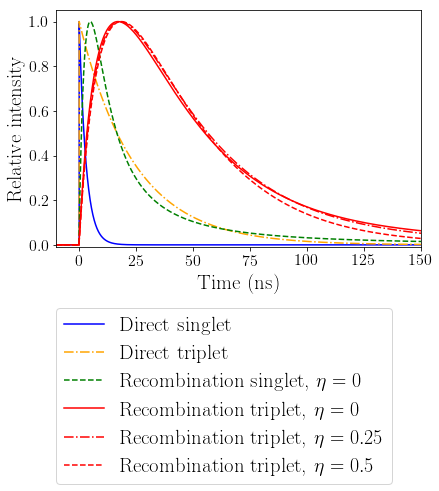

In [51]:
dt = 0.2
t = np.linspace(0, 250, 250/dt)
ts = 3
tt = 24
tr = 15
eta = 0.

Ids = Iex(t, ts)
Idt = Iex(t, tt)
Irs = Ir3(t, ts, tr, eta, 300, 3000)
Irt = Ir3(t, tt, tr, eta, 300, 3000)
Irt2 = Ir3(t, tt, tr, 0.25, 300, 3000)
Irt3 = Ir3(t, tt, tr, 0.5, 300, 3000)



for I, c, ls,  l in zip([Ids, Idt,Irs, Irt, Irt2, Irt3], 
                        ['blue', 'orange', 'green', 'red', 'red', 'red'],
                        ['solid', '-.', '--', 'solid', '-.', '--', 'solid'],
                        
                        
                        ['Direct singlet', 'Direct triplet', 
                                                  'Recombination singlet, $\eta = 0$', 
                                                  'Recombination triplet, $\eta = 0$',
                                                  'Recombination triplet, $\eta = 0.25$',
                                                  'Recombination triplet, $\eta = 0.5$',
                                                  'Recombination triplet, eta = 0.5']):
    # add a bunch of zeroes, just for a nicer plot
    t_before = np.linspace(-50, 0, 50/dt)
    I_before = np.zeros(50/dt)
    I_plot = np.concatenate([I_before, I])
    t_plot = np.concatenate([t_before, t])
    # Now normalize
    # I_plot = I_plot / (dt * np.sum(I_plot))
    I_plot = I_plot / np.max(I_plot)
    plt.plot(t_plot, I_plot, label = l, color = c, ls = ls)
plt.legend(loc=(0, -1))
plt.ylabel('Relative intensity')
plt.xlabel('Time (ns)')
plt.ylim(-0.01, 1.05)
plt.xlim(-10, 150)
plt.savefig('/home/erik/win/notes/Is.pdf', bbox_inches = 'tight')

### LY and CY measurements

In [4]:
with open('pickles/highfield_bands_1.0_sigmas_er_nr.pickle', 'rb') as f:
    cs1s, (er_low, er_mid, er_high), (nr_low, nr_mid, nr_high) = pickle.load(f)

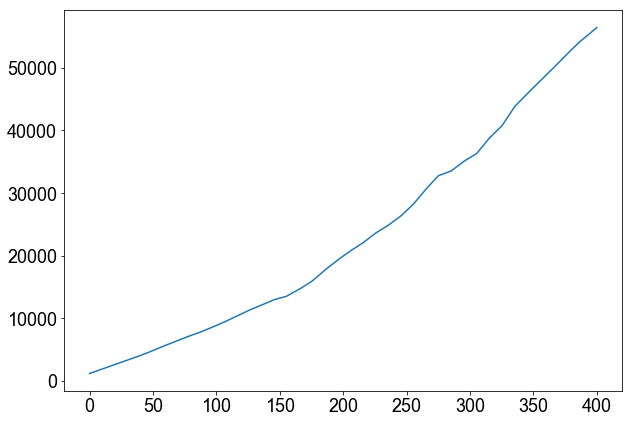

In [5]:
plt.plot(cs1s, er_mid)

In [42]:
# Taken from Measurement of light and charge yield of low-energy electronic recoils in liquid xenon
# At 480 V/cm
Er = np.arange(1.5, 27.5, 1)
dEr = np.ones(len(Er)) * 0.5
LY = np.array([
16.9,
25.4,
31.2,
34.0,
37.1,
38.1,
39.0,
39.4,
40.1,
41.1,
42.0,
41.3,
42.2,
42.5,
42.5,
42.5,
42.5,
42.7,
42.9,
42.8,
42.9,
42.9,
42.9,
42.6,
42.5,
42.9])

CY = np.array([
79.0,
53.6,
44.6,
40.5,
37.8,
35.6,
34.6,
33.9,
33.1,
32.6,
32.4,
32.1,
32.0,
31.8,
31.5,
31.5,
31.4,
31.3,
31.2,
31.6,
31.3,
31.2,
31.2,
31.6,
31.6,
31.6])



Er = np.concatenate([Er, np.arange(30, 112, 4)])
dEr = np.concatenate([dEr, np.ones(len(np.arange(30, 112, 4))) * 2])

LY = np.concatenate([LY, [
42.0,
41.6,
40.9,
40.4,
39.7,
39.0,
37.5,
37.1,
36.5,
35.7,
35.2,
34.5,
33.4,
33.1,
32.6,
31.7,
31.0,
30.9,
31.3,
30.3,
29.4]])

CY = np.concatenate([CY, [
32.0,
32.9,
33.5,
34.2,
35.0,
35.7,
36.0,
37.7,
38.6,
38.8,
39.3,
40.0,
41.1,
41.6,
42.2,
42.0,
43.5,
43.4,
43.2,
44.1,
44.0]])

# 42.0  0.3 32.0  0.2
# 41.6  0.3 32.9  0.2
# 40.9  0.3 33.5  0.2
# 40.4  0.2 34.2  0.2
# 39.7  0.2 35.0  0.2
# 39.0  0.2 35.7  0.2
# 37.5  0.2 36.0  0.2
# 37.1  0.2 37.7  0.2
# 36.5  0.2 38.6  0.2
# 35.7  0.2 38.8  0.2
# 35.2  0.2 39.3  0.2
# 34.5  0.2 40.0  0.3
# 33.4  0.2 41.1  0.3
# 33.1  0.3 41.6  0.3
# 32.6  0.3 42.2  0.3
# 31.7  0.3 42.0  0.4
# 31.0  0.3 43.5  0.4
# 30.9  0.3 43.4  0.4
# 31.3  0.5 43.2  0.5
# 30.3  0.4 44.1  0.4
# 29.4  0.4 44.0  0.5
    
# 28:0 􀀀 32:0 0.6 42.0  0.3 32.0  0.2
# 32:0 􀀀 36:0 0.6 41.6  0.3 32.9  0.2
# 36:0 􀀀 40:0 0.6 40.9  0.3 33.5  0.2
# 40:0 􀀀 44:0 0.6 40.4  0.2 34.2  0.2
# 44:0 􀀀 48:0 0.6 39.7  0.2 35.0  0.2
# 48:0 􀀀 52:0 0.6 39.0  0.2 35.7  0.2
# 52:0 􀀀 56:0 0.6 37.5  0.2 36.0  0.2
# 56:0 􀀀 60:0 0.6 37.1  0.2 37.7  0.2
# 60:0 􀀀 64:0 0.6 36.5  0.2 38.6  0.2
# 64:0 􀀀 68:0 0.6 35.7  0.2 38.8  0.2
# 68:0 􀀀 72:0 0.6 35.2  0.2 39.3  0.2
# 72:0 􀀀 76:0 0.6 34.5  0.2 40.0  0.3
# 76:0 􀀀 80:0 0.6 33.4  0.2 41.1  0.3
# 80:0 􀀀 84:0 0.6 33.1  0.3 41.6  0.3
# 84:0 􀀀 88:0 0.6 32.6  0.3 42.2  0.3
# 88:0 􀀀 92:0 0.6 31.7  0.3 42.0  0.4
# 92:0 􀀀 96:0 0.6 31.0  0.3 43.5  0.4
# 96:0 􀀀 100:0 0.6 30.9  0.3 43.4  0.4
# 100:0 􀀀 104:0 0.6 31.3  0.5 43.2  0.5
# 104:0 􀀀 108:0 0.6 30.3  0.4 44.1  0.4
# 108:0 􀀀 112:0 0.5 29.4  0.4 44.0  0.5

# 16.9  2.6 79.0  0.9
# 25.4  1.0 53.6  0.3
# 31.2  0.4 44.6  0.2
# 34.0  0.3 40.5  0.1
# 37.1  0.3 37.8  0.1
# 38.1  0.2 35.6  0.1
# 39.0  0.2 34.6  0.1
# 39.4  0.2 33.9  0.1
# 40.1  0.2 33.1  0.1
# 41.1  0.2 32.6  0.1
# 42.0  0.2 32.4  0.1
# 41.3  0.2 32.1  0.1
# 42.2  0.1 32.0  0.1
# 42.5  0.1 31.8  0.1
# 42.5  0.1 31.5  0.1
# 42.5  0.1 31.5  0.1
# 42.5  0.1 31.4  0.1
# 42.7  0.1 31.3  0.1
# 42.9  0.1 31.2  0.1
# 42.8  0.1 31.6  0.1
# 42.9  0.1 31.3  0.1
# 42.9  0.1 31.2  0.1
# 42.9  0.1 31.2  0.1
# 42.6  0.1 31.6  0.1
# 42.5  0.1 31.6  0.1
# 42.9  0.1 31.6  0.1




# 0:5 􀀀 1:5 0.6 16.9  2.6 79.0  0.9
# 1:5 􀀀 2:5 0.6 25.4  1.0 53.6  0.3
# 2:5 􀀀 3:5 0.6 31.2  0.4 44.6  0.2
# 3:5 􀀀 4:5 0.6 34.0  0.3 40.5  0.1
# 4:5 􀀀 5:5 0.6 37.1  0.3 37.8  0.1
# 5:5 􀀀 6:5 0.6 38.1  0.2 35.6  0.1
# 6:5 􀀀 7:5 0.6 39.0  0.2 34.6  0.1
# 7:5 􀀀 8:5 0.6 39.4  0.2 33.9  0.1
# 8:5 􀀀 9:5 0.6 40.1  0.2 33.1  0.1
# 9:5 􀀀 10:5 0.6 41.1  0.2 32.6  0.1
# 10:5 􀀀 11:5 0.6 42.0  0.2 32.4  0.1
# 11:5 􀀀 12:5 0.6 41.3  0.2 32.1  0.1
# 12:5 􀀀 13:5 0.6 42.2  0.1 32.0  0.1
# 13:5 􀀀 14:5 0.6 42.5  0.1 31.8  0.1
# 14:5 􀀀 15:5 0.6 42.5  0.1 31.5  0.1
# 15:5 􀀀 16:5 0.6 42.5  0.1 31.5  0.1
# 16:5 􀀀 17:5 0.6 42.5  0.1 31.4  0.1
# 17:5 􀀀 18:5 0.6 42.7  0.1 31.3  0.1
# 18:5 􀀀 19:5 0.6 42.9  0.1 31.2  0.1
# 19:5 􀀀 20:5 0.6 42.8  0.1 31.6  0.1
# 20:5 􀀀 21:5 0.6 42.9  0.1 31.3  0.1
# 21:5 􀀀 22:5 0.6 42.9  0.1 31.2  0.1
# 22:5 􀀀 23:5 0.6 42.9  0.1 31.2  0.1
# 23:5 􀀀 24:5 0.6 42.6  0.1 31.6  0.1
# 24:5 􀀀 25:5 0.6 42.5  0.1 31.6  0.1
# 25:5 􀀀 26:5 0.6 42.9  0.1 31.6  0.1

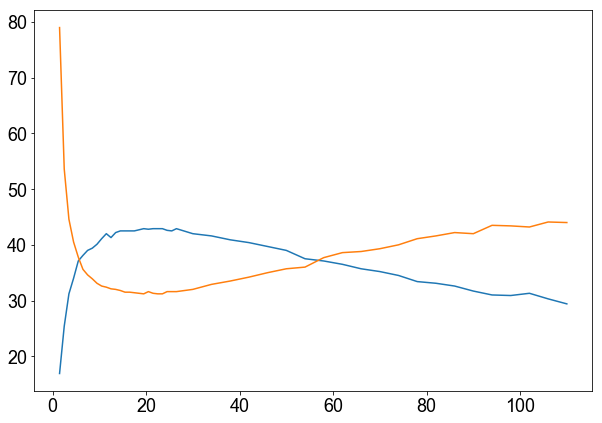

In [43]:
plt.plot(Er, LY)
plt.plot(Er, CY)

In [44]:
4.7 / (1 - 0.698)

15.562913907284766

In [50]:
S2 = CY * Er * 15.56
S1 = LY * Er * 0.10

(0, 100000)

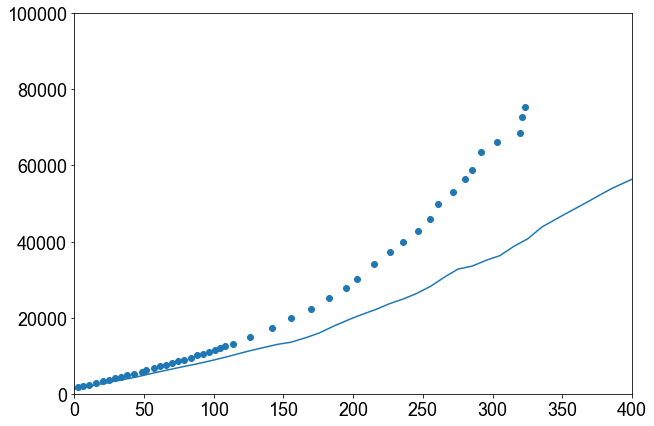

In [51]:
plt.scatter(S1, S2)
plt.plot(cs1s, er_mid)
plt.xlim(0, 400)
plt.ylim(0, 100000)